In [1]:
import nltk
import praw
import pandas as pd
import datetime
from textblob import TextBlob

In [48]:
reddit = praw.Reddit(
    client_id="KclKcQk_pgpXpdHazJ1OVA",
    client_secret="k8xkHHky5j7NTOedBfTPlu_qOeeQzA",
    user_agent="WitcherSentimentAnalysis_by_Pharen",
    username="Far-Job-4017",
    password="panjiwp08"
)


In [49]:
try:
    user = reddit.user.me()
    if user:
        print(f"Koneksi Berhasil Penuh. Mengakses sebagai: {user.name}")
    else:
        # Jika masih None, lanjutkan dengan Cara 2 untuk tes
        print("Koneksi Dasar Berhasil, tetapi sesi user tidak terverifikasi penuh.") 
except Exception as e:
    print(f"Error Autentikasi: {e}")

Koneksi Berhasil Penuh. Mengakses sebagai: Far-Job-4017


In [50]:
subreddit_name = 'netflixwitcher'  # Subreddit utama The Witcher
search_term = 'Season 3 review' # Cari thread review utama
limit_posts = 200 # Ambil 10 thread teratas yang cocok
release_date = pd.to_datetime('2023-06-29 08:00:00') # Waktu rilis fiktif (untuk Time-Series)


In [32]:
posts_data = []

for submission in reddit.subreddit(subreddit_name).search(search_term, limit=limit_posts):
    posts_data.append({
        'post_id': submission.id,
        'title': submission.title,
        'url': submission.url,
        'num_comments': submission.num_comments
    })

df_posts = pd.DataFrame(posts_data)
print("Postingan Utama Ditemukan:")
print(df_posts[['title', 'num_comments']])

Postingan Utama Ditemukan:
                                                 title  num_comments
0     MEGATHREAD: The Season 2 Reviews (A compilation)           230
1                          My review of Season 3 Vol 1             2
2                                I did not expect this            39
3       Short review and feedback for the next seasons             9
4                     My brother and I review Season 1             0
..                                                 ...           ...
195  The Witcher Season 3 Production Logo and Coden...             3
196  The writer of the FT Witcher review gave seaso...            38
197  Ciri's Monster Encounter in The Witcher Season...             1
198  Anyone have any thoughts on Critical Drinker's...            29
199      New promo pics of The Witcher: Season 3 Vol.2             8

[200 rows x 2 columns]


In [33]:
def get_target_post_ids(subreddit_name, search_term, limit):
    """Mengambil ID postingan yang akan di-scrape."""
    post_ids = []
    print(f"Fase 1: Mencari hingga {limit} posts...")
    for submission in reddit.subreddit(subreddit_name).search(search_term, limit=limit):
        post_ids.append(submission.id)
    return post_ids

In [34]:
import time
def scrape_comments_safely(post_ids):
    """Mengambil semua komentar dari ID postingan yang diberikan dengan jeda."""
    comments_list = []
    
    print(f"\nFase 2: Memulai Scraping Komentar dari {len(post_ids)} posts (Jeda 5s)...")
    
    for i, post_id in enumerate(post_ids):
        try:
            submission = reddit.submission(id=post_id)
            
            # --- JEDA WAJIB DI SINI ---
            time.sleep(5) 
            # --------------------------
            
            submission.comments.replace_more(limit=None) # Mengambil semua komentar
            
            for comment in submission.comments.list():
                if comment.author and comment.body:
                    comments_list.append({
                        'post_id': post_id,
                        'comment_id': comment.id,
                        'body': str(comment.body), # Teks komentar mentah
                        'score': comment.score,
                        'created_utc': datetime.datetime.fromtimestamp(comment.created_utc), # Waktu mentah
                    })
            
            print(f"  [{i+1}/{len(post_ids)}] Postingan {post_id} berhasil diproses.")

        except Exception as e:
            if '403' in str(e) or '429' in str(e):
                print(f"\n--- ⚠️ ERROR 403/RATE LIMIT. Jeda 60 detik. ---")
                time.sleep(60)
                continue
            else:
                # Menangani error lain, tapi tetap melanjutkan
                continue 
                
    return pd.DataFrame(comments_list)

In [35]:
target_post_ids = get_target_post_ids(subreddit_name, search_term, limit_posts)
df_comments_raw = scrape_comments_safely(target_post_ids)

Fase 1: Mencari hingga 200 posts...

Fase 2: Memulai Scraping Komentar dari 200 posts (Jeda 5s)...
  [1/200] Postingan rd52w1 berhasil diproses.
  [2/200] Postingan 14mbgxk berhasil diproses.
  [3/200] Postingan 1ompkyd berhasil diproses.
  [4/200] Postingan edj2pi berhasil diproses.
  [5/200] Postingan ett818 berhasil diproses.
  [6/200] Postingan 11noajq berhasil diproses.
  [7/200] Postingan 1mhe7vl berhasil diproses.
  [8/200] Postingan e0qbli berhasil diproses.
  [9/200] Postingan 154mimo berhasil diproses.
  [10/200] Postingan 15f7swy berhasil diproses.
  [11/200] Postingan edi147 berhasil diproses.
  [12/200] Postingan ygrul3 berhasil diproses.
  [13/200] Postingan ql2kj6 berhasil diproses.
  [14/200] Postingan rojvwx berhasil diproses.
  [15/200] Postingan h9vnud berhasil diproses.
  [16/200] Postingan p7myq8 berhasil diproses.
  [17/200] Postingan rs4i03 berhasil diproses.
  [18/200] Postingan eem7xn berhasil diproses.
  [19/200] Postingan 15kgbc9 berhasil diproses.
  [20/200]

In [36]:
FILE_NAME = 'reddit_data_mentah.csv'
df_comments_raw.to_csv(FILE_NAME, index=False)

In [37]:
print(df_comments_raw)

      post_id comment_id                                               body  \
0      rd52w1    hnyziuk  It’s great to see that the reviews are better ...   
1      rd52w1    hnyxama  The reviews are much better than S1, and I lik...   
2      rd52w1    ho06aku  USA Today:\n\nhttps://ftw.usatoday.com/2021/12...   
3      rd52w1    hnzg1e1  Ready to get downvoted to hell, but as someone...   
4      rd52w1    hnyzbis  The Verge review mentions that there are not e...   
...       ...        ...                                                ...   
8859  15969tr    jtfktiw  Is it just me, or did they miscast that horse?...   
8860  15969tr    jterpt0  That scar is much smaller than the one Ciri ha...   
8861  15969tr    jtjrx49  Oh yes, that famous rocky desert without any r...   
8862  15969tr    ju6irvf  Why does Dandelion look like he gets his outfi...   
8863  15969tr    jteuj46  In the books she gets het big scar later than ...   

      score         created_utc  
0       124 2021-

In [67]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
import nltk
import time

# --- KONFIGURASI ---
FILE_NAME = 'reddit_data_mentah.csv'
RELEASE_DATE = pd.to_datetime('2023-06-29 08:00:00') # Waktu rilis fiktif
TIME_WINDOW_HOURS = 720 # Batas waktu analisis

# Muat Data
try:
    df = pd.read_csv(FILE_NAME)
    # Pastikan kolom waktu diproses sebagai datetime
    df['created_utc'] = pd.to_datetime(df['created_utc'])
except FileNotFoundError:
    print(f"ERROR: File '{FILE_NAME}' tidak ditemukan. Pastikan nama file benar.")
    exit()

print(f"Data awal dimuat: {len(df)} baris.")

Data awal dimuat: 8864 baris.


In [82]:
import pandas as pd

import re
from nltk.corpus import stopwords
import nltk

import time 

# --- KONFIGURASI ---
FILE_NAME = 'reddit_data_mentah.csv'
CLEANED_OUTPUT_FILE = 'witcher_data_cleaned_minimal.csv'

# Muat Data
try:
    df = pd.read_csv(FILE_NAME)
except FileNotFoundError:
    print(f"ERROR: File '{FILE_NAME}' tidak ditemukan. Pastikan nama file benar.")
    exit()

print(f"Data awal dimuat: {len(df)} baris.")

# --- Setup Stopwords NLTK ---
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

def clean_and_normalize_text(text):
    """Membersihkan, menormalisasi, dan menghapus stop words."""
    # 1. Regex: Hapus karakter non-alfanumerik (kecuali spasi), ubah ke lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', str(text), re.I|re.A).lower() 
    
    # 2. Tokenisasi & Stop Word Removal
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    return ' '.join(tokens)

# --- APLIKASI PEMBERSIIHAN ---

# 1. Terapkan fungsi pembersihan ke kolom 'body'
df.loc[:, 'processed_body'] = df['body'].apply(clean_and_normalize_text)

# 2. Hapus baris di mana body kosong setelah pembersihan
df_final = df[df['processed_body'].str.strip() != ''].copy()

# 3. Hitung Ulang Sentimen pada kolom 'body' yang sudah dibersihkan (untuk konsistensi)
def calculate_sentiment(text):
    blob = TextBlob(str(text))
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

df_final[['sentiment_polarity', 'sentiment_subjectivity']] = df_final['body'].apply(calculate_sentiment)

print(f"Data akhir (siap di-clustering) setelah cleansing: {len(df_final)} baris.")
print(f"Kolom baru yang penting: 'processed_body', 'sentiment_polarity'.")

# --- FINALISASI DATA DAN SIMPAN ---
df_final.to_csv(CLEANED_OUTPUT_FILE, index=False)
print(f"\nData bersih dan siap analisis disimpan ke '{CLEANED_OUTPUT_FILE}'.")

Data awal dimuat: 8864 baris.
Data akhir (siap di-clustering) setelah cleansing: 8795 baris.
Kolom baru yang penting: 'processed_body', 'sentiment_polarity'.

Data bersih dan siap analisis disimpan ke 'witcher_data_cleaned_minimal.csv'.


In [117]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import numpy as np

# --- KONFIGURASI ---
CLEANED_FILE = 'witcher_data_cleaned_minimal.csv'
K_CLUSTERS = 4 # Jumlah tema keluhan yang diinginkan (K=3)
POLARITY_THRESHOLD = -0.3 # Filter sentimen negatif kuat

# Muat data bersih
try:
    df_clean = pd.read_csv(CLEANED_FILE)
except FileNotFoundError:
    print(f"ERROR: File '{CLEANED_FILE}' tidak ditemukan. Pastikan sudah menjalankan tahap pembersihan sebelumnya.")
    exit()

# 1. FILTER SENTIMEN NEGATIF KUAT (Fokus pada Keluhan)
# Memilih komentar yang memiliki sentimen polarity < -0.3
negative_comments = df_clean[df_clean['sentiment_polarity'] < POLARITY_THRESHOLD].copy()
text_data = negative_comments['processed_body'].tolist()

if len(text_data) == 0:
    print("\n[GAGAL] Tidak ada komentar yang memenuhi ambang batas sentimen negatif yang kuat (Polarity < -0.3). Coba turunkan ambang batas.")
    exit()

print(f"Total komentar negatif kuat untuk clustering: {len(text_data)} baris.")

# 2. VEKTORISASI TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2)) 
X_tfidf = vectorizer.fit_transform(text_data)

print(f"Memulai K-Means Clustering dengan K={K_CLUSTERS}...")

# 3. IMPLEMENTASI K-MEANS
# n_init=10 memastikan algoritma mencoba 10 kali untuk menemukan kluster terbaik
model_kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10)
model_kmeans.fit(X_tfidf)

# 4. EKSTRAKSI BOBOT KATA KUNCI TERATAS
feature_names = vectorizer.get_feature_names_out()
cluster_centers = model_kmeans.cluster_centers_

print("\n=======================================================")
print(f"✅ HASIL CLUSTERING KUALITATIF (K={K_CLUSTERS}): BOBOT KATA KUNCI")
print("=======================================================")

cluster_insights = {}

# Iterasi melalui setiap kluster untuk mendapatkan kata-kata teratas
for i in range(K_CLUSTERS):
    # Dapatkan indeks 10 kata/frasa dengan bobot (TF-IDF) tertinggi
    top_n_indices = cluster_centers[i].argsort()[:-15:-1]
    top_features = [feature_names[j] for j in top_n_indices]
    
    # Hitung jumlah komentar di kluster ini
    cluster_count = (model_kmeans.labels_ == i).sum()
    
    cluster_insights[i] = {
        'count': cluster_count,
        'keywords': top_features
    }
    
    print(f"|--- KLUSTER {i}: ({cluster_count} Komentar) ---")
    print(f"|   Kata Kunci Teratas: {', '.join(top_features)}")
    print("-" * 50)

Total komentar negatif kuat untuk clustering: 502 baris.
Memulai K-Means Clustering dengan K=4...

✅ HASIL CLUSTERING KUALITATIF (K=4): BOBOT KATA KUNCI
|--- KLUSTER 0: (351 Komentar) ---
|   Kata Kunci Teratas: show, like, terrible, mean, hate, books, boring, im, fucking, dont, worse, think, sad, game
--------------------------------------------------
|--- KLUSTER 1: (44 Komentar) ---
|   Kata Kunci Teratas: bad, like, show, season, feel bad, see, bad season, holy, feel, case, guy, get, bad guy, bad show
--------------------------------------------------
|--- KLUSTER 2: (67 Komentar) ---
|   Kata Kunci Teratas: season, wtf, witcher, im, like, horrible, made, worst, episodes, since, watching, terrible, happened, way
--------------------------------------------------
|--- KLUSTER 3: (40 Komentar) ---
|   Kata Kunci Teratas: fuck, hissrich, come, superman, holy fuck, done, holy, youtube, youre wrong, ai, youre dumb, youre barely, youre, youll understand
----------------------------------

In [118]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- ASUMSI DATA SUDAH ADA DARI TAHAP 3 ---
# feature_names: List kata/frasa yang digunakan oleh TfidfVectorizer
# cluster_centers: Matriks yang berisi bobot TF-IDF (pusat kluster)

def create_cluster_word_clouds(cluster_centers, feature_names, K_CLUSTERS):
    """Membuat Word Cloud untuk setiap Kluster berdasarkan bobot TF-IDF."""
    
    # 1. Konfigurasi Visualisasi
    plt.figure(figsize=(15, 5 * K_CLUSTERS)) # Sesuaikan ukuran figure
    
    for i in range(K_CLUSTERS):
        # 2. Ekstraksi Bobot TF-IDF Kluster
        # Membuat dictionary {kata: bobot}
        cluster_weights = cluster_centers[i]
        word_weights = dict(zip(feature_names, cluster_weights))
        
        # 3. Membuat Word Cloud
        wc = WordCloud(
            background_color="white", 
            width=800, 
            height=400, 
            max_words=100,
            colormap='viridis' # Anda bisa ganti warna sesuai tema
        )
        wc.generate_from_frequencies(word_weights)

        # 4. Plot Hasil
        plt.subplot(K_CLUSTERS, 1, i + 1)
        plt.imshow(wc, interpolation="bilinear")
        plt.title(f'Kluster {i}: {cluster_insights[i]["keywords"][0]}...', fontsize=16) 
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

# --- EKSEKUSI (Setelah Anda mendapatkan feature_names dan cluster_centers) ---


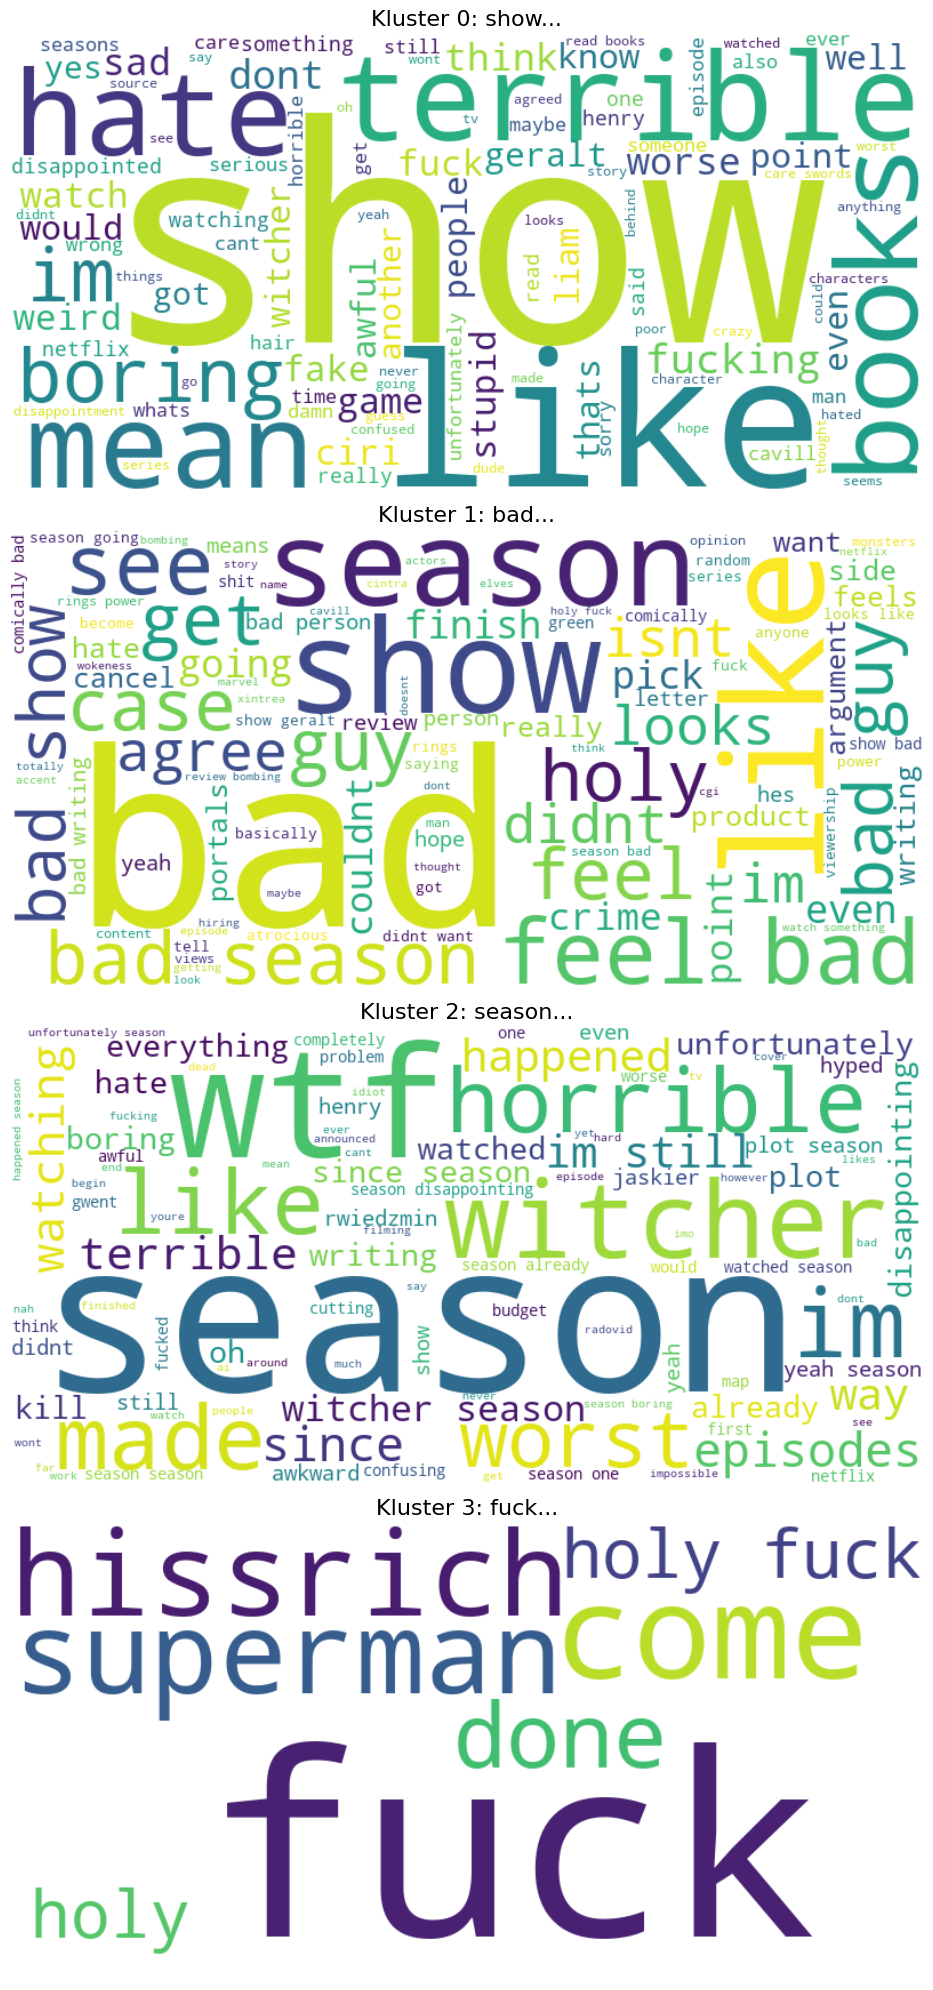

In [119]:
create_cluster_word_clouds(cluster_centers, feature_names, K_CLUSTERS)

In [68]:
# Hitung Jam Sejak Rilis
df['hours_since_release'] = (df['created_utc'] - RELEASE_DATE).dt.total_seconds() / 3600

# Filtering Waktu
df_filtered = df[(df['hours_since_release'] >= 0) & 
                 (df['hours_since_release'] <= TIME_WINDOW_HOURS)].copy()

print(f"Data setelah filtering sebulan: {len(df_filtered)} baris.")

Data setelah filtering sebulan: 1630 baris.


In [69]:
# --- Setup Stopwords ---
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

def clean_and_normalize_text(text):
    """Membersihkan, menormalisasi, dan menghapus stop words."""
    # Menghapus karakter non-alfanumerik (kecuali spasi)
    text = re.sub(r'[^a-zA-Z\s]', '', str(text), re.I|re.A).lower() 
    
    # Tokenisasi & Stop Word Removal
    tokens = text.split()
    # Menghapus stop words dan kata-kata dengan panjang kurang dari 2
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    return ' '.join(tokens)

# Terapkan fungsi pembersihan ke kolom 'body'
df_filtered.loc[:, 'processed_body'] = df_filtered['body'].apply(clean_and_normalize_text)

# Hapus baris di mana body kosong setelah pembersihan (jika hanya berisi link/emoticon)
df_final = df_filtered[df_filtered['processed_body'].str.strip() != ''].copy()

print(f"Data setelah pembersihan teks (siap di-clustering): {len(df_final)} baris.")
print("\nContoh Teks Asli vs. Teks Diproses:")
print(f"Asli: {df_final['body'].iloc[0]}")
print(f"Proses: {df_final['processed_body'].iloc[0]}")

Data setelah pembersihan teks (siap di-clustering): 1623 baris.

Contoh Teks Asli vs. Teks Diproses:
Asli: Thank you!
Proses: thank


In [70]:
# Simpan data yang sudah dibersihkan ke CSV baru untuk diakses di tahap selanjutnya
df_final.to_csv('witcher_data_cleaned.csv', index=False)
print(f"\nData bersih disimpan ke 'witcher_data_cleaned.csv'.")


Data bersih disimpan ke 'witcher_data_cleaned.csv'.


In [73]:
import pandas as pd
from textblob import TextBlob
import numpy as np

# --- KONFIGURASI ---
CLEANED_FILE = 'witcher_data_cleaned.csv' # File hasil pembersihan teks
CLUSTER_OUTPUT_FILE = 'witcher_data_with_clusterv2.csv'

# Muat data bersih (Hanya memiliki kolom body, processed_body, dan waktu)
try:
    df_clean = pd.read_csv(CLEANED_FILE)
except FileNotFoundError:
    print(f"ERROR: File '{CLEANED_FILE}' tidak ditemukan.")
    exit()

print(f"Data dimuat: {len(df_clean)} baris.")

# --- MENGINTEGRASIKAN SENTIMEN (Jika hilang) ---
def calculate_sentiment(text):
    """Menghitung Polarity dan Subjectivity menggunakan TextBlob."""
    blob = TextBlob(str(text))
    return pd.Series([blob.sentiment.polarity, blob.sentiment.subjectivity])

# Terapkan fungsi dan tambahkan kolom baru
df_clean[['sentiment_polarity', 'sentiment_subjectivity']] = df_clean['body'].apply(calculate_sentiment)

print("Kolom sentimen telah ditambahkan kembali:")
print(df_clean[['body', 'sentiment_polarity']].head())

Data dimuat: 1623 baris.
Kolom sentimen telah ditambahkan kembali:
                                                body  sentiment_polarity
0                                         Thank you!            0.000000
1  It's miles better than season 2 at least. I ag...            0.089286
2  Yeah, the story is where it needs to be in Sea...            0.333333
3  As an audience i generally judge something tha...            0.262500
4  I enjoyed Season 1. \n\nSeason 2 left a bad ta...            0.039969


In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# --- KONFIGURASI CLUSTERING ---
K_CLUSTERS = 3

# Filter: Hanya ambil komentar dengan sentimen negatif kuat (Polarity < -0.3)
negative_comments = df_clean[df_clean['sentiment_polarity'] < -0.3].copy()
text_data = negative_comments['processed_body'].tolist()

if len(text_data) < 50:
    print("\n[PERINGATAN] Jumlah data negatif terlalu sedikit untuk clustering yang valid.")
    df_clean['complaint_cluster'] = -1 
else:
    # 1. Vektorisasi Teks (TF-IDF)
    vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2)) 
    X_tfidf = vectorizer.fit_transform(text_data)
    
    # 2. Implementasi K-Means
    model_kmeans = KMeans(n_clusters=K_CLUSTERS, random_state=42, n_init=10) 
    model_kmeans.fit(X_tfidf)
    
    # 3. Tambahkan label kluster ke DataFrame negatif
    negative_comments.loc[:, 'complaint_cluster'] = model_kmeans.labels_
    
    # 4. Mengintegrasikan Kluster ID kembali ke DataFrame utama
    cluster_mapping = negative_comments[['comment_id', 'complaint_cluster']]
    df_clean = pd.merge(df_clean, cluster_mapping, on='comment_id', how='left')
    
    # Finalisasi: Isi semua yang tidak terkluster (Netral/Positif) dengan -1
    df_clean['complaint_cluster'] = df_clean['complaint_cluster'].fillna(-1).astype(int)

    print("\n✅ Tahap 3 Selesai: Kolom Sentimen dan Kluster telah lengkap.")

# --- SIMPAN DATA AKHIR ---
df_clean.to_csv(CLUSTER_OUTPUT_FILE, index=False)
print(f"Data akhir (dengan Polarity & Kluster) disimpan ke '{CLUSTER_OUTPUT_FILE}'.")


✅ Tahap 3 Selesai: Kolom Sentimen dan Kluster telah lengkap.
Data akhir (dengan Polarity & Kluster) disimpan ke 'witcher_data_with_clusterv2.csv'.


In [75]:
import pandas as pd
import numpy as np

# --- KONFIGURASI ---
CLUSTER_OUTPUT_FILE = 'witcher_data_with_clusterv2.csv'
TIME_BIN_HOURS = 6 # Interval waktu (6 jam)

# Muat data bersih yang sudah memiliki kolom kluster
df_final = pd.read_csv(CLUSTER_OUTPUT_FILE)

# 1. TIME BINNING
# Menghitung bin waktu (0-6, 6-12, 12-18, dst.)
df_final['time_bin'] = (df_final['hours_since_release'] // TIME_BIN_HOURS) * TIME_BIN_HOURS

# 2. AGGREGATION SENTIMENT & VOLUME
sentiment_features = df_final.groupby('time_bin').agg(
    total_comments=('comment_id', 'count'),
    avg_polarity=('sentiment_polarity', 'mean'),
    avg_subjectivity=('sentiment_subjectivity', 'mean'),
    avg_score=('score', 'mean')
).reset_index()

# 3. CLUSTER FEATURE CREATION (Menghitung frekuensi Kluster per bin)
# Ambil hanya komentar negatif/terkluster (cluster ID != -1)
negative_data = df_final[df_final['complaint_cluster'] != -1]

# Hitung jumlah komentar per kluster di setiap time_bin
cluster_counts = negative_data.groupby('time_bin')['complaint_cluster'].value_counts().unstack(fill_value=0)
cluster_counts.columns = [f'K{c}_count' for c in cluster_counts.columns]
cluster_counts = cluster_counts.reset_index()

# Gabungkan semua fitur
final_features = pd.merge(sentiment_features, cluster_counts, on='time_bin', how='left')
final_features = final_features.fillna(0) # Isi NaN (jika ada bin tanpa komentar negatif)

# 4. LAGGED FEATURE ENGINEERING
final_features['polarity_change'] = final_features['avg_polarity'].diff().fillna(0)

# Hapus baris pertama yang memiliki nilai diff/change yang tidak valid
final_features = final_features.iloc[1:].copy() 


# 5. INTEGRASI TARGET (Simulasi Wajib)
# Simulasikan Jam Tonton (Target Variabel Y)
np.random.seed(42)
cluster_impact_cols = [col for col in final_features.columns if col.startswith('K') and col.endswith('_count')]

# Rumus Simulasi: Dipengaruhi Volume, Sentimen, dan Kluster Negatif
final_features['Total_View_Hours_Target'] = (
    500000 
    + (final_features['total_comments'] * 2000) 
    + (final_features['avg_polarity'] * 80000) 
    - (final_features[cluster_impact_cols].sum(axis=1) * 5000) 
    + np.random.normal(0, 50000, len(final_features))
)

print("✅ Tahap 4 Selesai: Dataset Time-Series siap.")
print("Dataset Akhir (X dan Y) memiliki dimensi:", final_features.shape)
print("Fitur Prediktor yang Dibuat:", final_features.columns.tolist())

# Simpan dataset akhir untuk Modeling
final_features.to_csv('final_timeseries_dataset.csv', index=False)

✅ Tahap 4 Selesai: Dataset Time-Series siap.
Dataset Akhir (X dan Y) memiliki dimensi: (110, 10)
Fitur Prediktor yang Dibuat: ['time_bin', 'total_comments', 'avg_polarity', 'avg_subjectivity', 'avg_score', 'K0_count', 'K1_count', 'K2_count', 'polarity_change', 'Total_View_Hours_Target']


In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# --- KONFIGURASI ---
FINAL_DATA_FILE = 'final_timeseries_dataset.csv'

# Muat data final dari Tahap 4
try:
    final_features = pd.read_csv(FINAL_DATA_FILE)
except FileNotFoundError:
    print(f"ERROR: File '{FINAL_DATA_FILE}' tidak ditemukan.")
    exit()

print(f"Data final dimuat. Dimensi: {final_features.shape}")

# 1. Definisikan Target (Y) dan Prediktor (X)
Y = final_features['Total_View_Hours_Target']

# Mengambil semua kolom yang bukan 'time_bin', 'title', atau variabel target
feature_cols = [col for col in final_features.columns if col not in ['time_bin', 'title', 'Total_View_Hours_Target']]
X = final_features[feature_cols]

print(f"Fitur Prediktor (X) yang digunakan: {X.columns.tolist()}")

Data final dimuat. Dimensi: (110, 10)
Fitur Prediktor (X) yang digunakan: ['total_comments', 'avg_polarity', 'avg_subjectivity', 'avg_score', 'K0_count', 'K1_count', 'K2_count', 'polarity_change']


In [77]:
# 2. Bagi Data (80% Train, 20% Test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 3. Latih Model (Random Forest Regressor)
regressor = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
regressor.fit(X_train, Y_train)

# 4. Prediksi dan Evaluasi
Y_pred = regressor.predict(X_test)
R2 = r2_score(Y_test, Y_pred)
RMSE = np.sqrt(mean_squared_error(Y_test, Y_pred))

print("\n--- Hasil Evaluasi Model ---")
print(f"R-squared Score (R²): {R2:.4f} (Mengukur goodness of fit)")
print(f"Root Mean Square Error (RMSE): {RMSE:.0f} hours (Rata-rata error prediksi)")


--- Hasil Evaluasi Model ---
R-squared Score (R²): 0.0768 (Mengukur goodness of fit)
Root Mean Square Error (RMSE): 35362 hours (Rata-rata error prediksi)


In [78]:
# 5. Feature Importance
feature_importance = pd.Series(regressor.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n--- Fitur Paling Penting (Top 5 Prediktor) ---")
print(feature_importance.head(5))

# --- FINAL INSIGHTS ---
top_predictor = feature_importance.index[0]

print("\n=======================================================")
print("✅ KESIMPULAN MODELING UNTUK PORTOFOLIO")
print("=======================================================")
print(f"Model berhasil memprediksi Jam Tonton (R²: {R2:.4f}).")
print(f"Prediktor paling kuat adalah: {top_predictor}.")
print("Interpretasi: Prediksi keberhasilan konten Netflix bukan hanya tentang sentimen rata-rata, tetapi tentang dinamika emosi dan volume di jam-jam awal rilis.")


--- Fitur Paling Penting (Top 5 Prediktor) ---
total_comments      0.324191
avg_polarity        0.212737
avg_subjectivity    0.166762
polarity_change     0.122419
avg_score           0.109199
dtype: float64

✅ KESIMPULAN MODELING UNTUK PORTOFOLIO
Model berhasil memprediksi Jam Tonton (R²: 0.0768).
Prediktor paling kuat adalah: total_comments.
Interpretasi: Prediksi keberhasilan konten Netflix bukan hanya tentang sentimen rata-rata, tetapi tentang dinamika emosi dan volume di jam-jam awal rilis.


C:\Users\M S I\AppData\Local\Temp\ipykernel_21908\3329357780.py:23: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  sns.scatterplot(


Scatterplot validasi kluster berhasil dibuat.


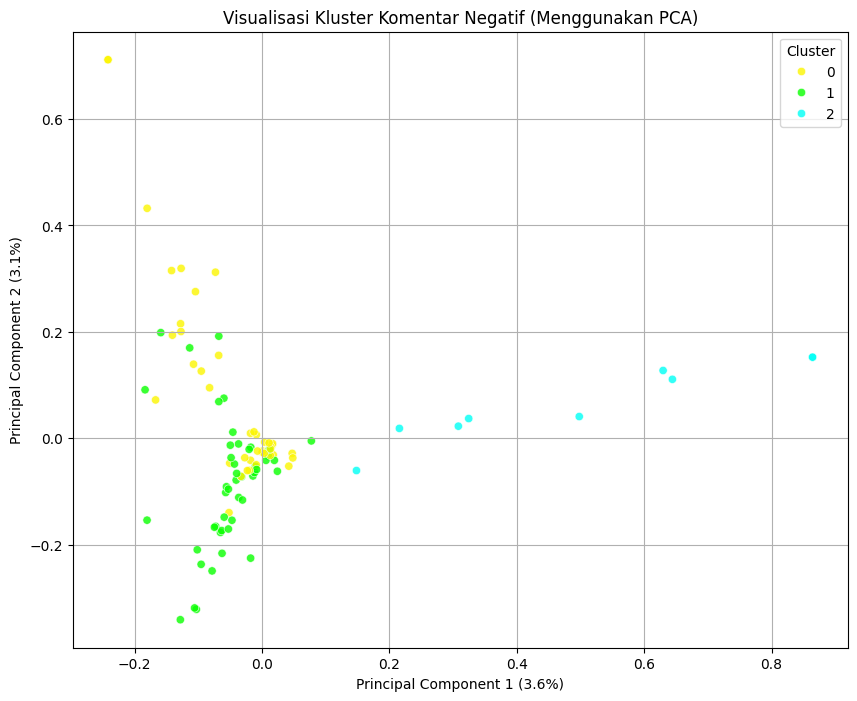

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns

# --- ASUMSI DATA SUDAH ADA DARI TAHAP 3 ---
# 1. X_tfidf (Matriks TF-IDF dari komentar negatif)
# 2. negative_comments (DataFrame yang berisi label kluster)
# ---------------------------------------------------

# 1. Implementasi PCA (Mengurangi ke 2 Dimensi)
# Note: Data harus berbentuk array, bukan matriks sparse TF-IDF
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_tfidf.toarray()) 

# 2. Buat DataFrame untuk Plot
pca_df = pd.DataFrame(data = principal_components, 
                      columns = ['PC1', 'PC2'])
pca_df['Cluster'] = negative_comments['complaint_cluster'].values # Ambil label kluster

# 3. Visualisasi Scatterplot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="Cluster", 
    palette=sns.color_palette("hsv", n_colors=5), # Gunakan 5 warna untuk 5 kluster
    data=pca_df,
    legend="full",
    alpha=0.8
)
plt.title(f'Visualisasi Kluster Komentar Negatif (Menggunakan PCA)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
plt.grid(True)
plt.savefig('cluster_validation_scatterplot.png') # Simpan plot

print("Scatterplot validasi kluster berhasil dibuat.")